# Topic Modelling with `tfp` built-in Variational Inference Methods

This notebook presents TensorFlow Probability-VI application to LDA. Orientation: https://colab.research.google.com/github/tensorflow/probability/blob/main/tensorflow_probability/examples/jupyter_notebooks/Variational_Inference_and_Joint_Distributions.ipynb

---

## Setup

In [35]:
import tensorflow_probability as tfp
import tensorflow as tf
tfd = tfp.distributions
tfb = tfp.bijectors
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

np.random.seed(42)
tf.random.set_seed(42)

In [36]:
## from ../src
import sys
if "../" not in sys.path: sys.path.append("../")

import src.utils   as tpc_utils # `tpc` abbreviates "topic"
import src.data    as tpc_data
import src.sampler as tpc_sampler

---

## Data Generation
Configurations of the dataset

In [37]:
N_docs       = 1000
sqrt_N_vocab = 3
N_words      = 100

## Variable Document Lengths?
uniform_doclengths = False
## Surrogate Posterior dist-class
use_build_factored_surrogate_posterior = True 
## Unconstraining Bijectors
use_softmax = True # Else softplus is used

N_topics = int(2*sqrt_N_vocab)
N_vocab  = int(sqrt_N_vocab**2)

## Generating Data

In [38]:
data = tpc_data.squareLDDocuments(
    N_docs=N_docs, 
    sqrt_N_vocab=sqrt_N_vocab, 
    N_words=N_words,
    uniform_doclengths=uniform_doclengths)

In [39]:
Theta, Pi, C_DId, C_DIdK, words = data.extract_params()

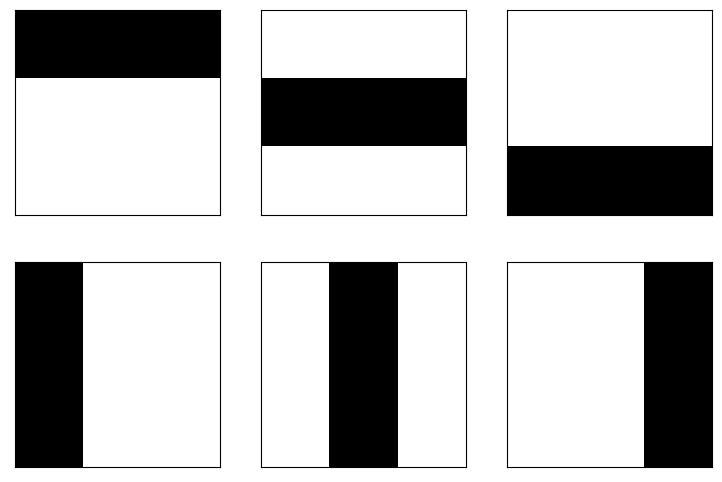

In [40]:
_ = tpc_utils.visualize_topics(Theta, N_row=2, N_col=3)

---

## Inference

### Preprocessing the Data

If the document length is variable, `tfp` methods are not properly applicable, because as of 2022-11-15 it lacks capabilities for processing `tf.RaggedTensor`'s. Thus no (joint)-distribution can be defined which samples variable-length documents. The idea is, to pad each document to the size of the longest document base on the observed frequency of each token in the document in a catrgorical-distributed manner:

$$
    X_{\textsf{pad}}^{(j)} \overset{\textsf{iid}}{\sim} \textsf{Categorcial}\left( \frac{\textsf{count}(x_i)}{\textsf{len}(\textsf{doc}_j)}; \ i =1,\dots, V \right)
$$

This should work becaus topic models are bag-of-words models where only the (relative) frequency of token occurances matter.

In [41]:
if ragged:
    pad_token = N_vocab + 1
    single_doclengths = words.nested_row_lengths()[0].numpy()
    N_words = tf.reduce_max(single_doclengths)

    words_ragged = words.to_tensor(N_vocab+1).numpy() # Renaming the previous words object.
    words = []

    def pad_single_doc(doc, length, N_words_max=N_words):
        pad_size    = N_words_max - length
        doc_padded  = doc
        doc         = doc[doc != pad_token]
        idx, freq   = np.unique(doc, return_counts=True)
        freq        = freq / np.sum(freq)
        pad         = np.random.choice(idx, size=pad_size, p=freq)
        doc_padded[doc_padded == pad_token] = pad
        return doc_padded

    for doc, length in zip(words_ragged, single_doclengths):
        words.append(pad_single_doc(doc, length))
    
    words = tf.constant(words, dtype=tf.int32)

---

## Defining the Joint

Orientation was provided by https://www.tensorflow.org/probability/examples/A_Tour_of_TensorFlow_Probability. Let $V$ be the size of the vocabulary, $D$ be the number of documents, $N$ be the (maximum) document size and $K$ be the number of topics. In this toy model which provides practical visualization capabilities we have $\sqrt{V} \in \mathbb N$ and $K=2*\sqrt{V} \in \mathbb N$.

The Joint Model then is:

In [42]:
## Priors:
alphas = tf.ones((N_docs, N_topics),  dtype=tf.float32)
betas  = tf.ones((N_topics, N_vocab), dtype=tf.float32)      
## Joint
joint = tfd.JointDistributionNamed(
    dict(
        Pi    = tfd.Dirichlet(alphas),
        Theta = tfd.Dirichlet(betas),
        W     = lambda Pi, Theta: tfd.Sample(  
            tfd.MixtureSameFamily(
                mixture_distribution=tfd.Categorical(probs=Pi),
                components_distribution=tfd.Categorical(probs=Theta)),
            sample_shape=N_words)),
    batch_ndims=0,
    use_vectorized_map=True)

Testing the joint:

In [43]:
## Sampling behavior 
sample = joint.sample()
for key, val in sample.items():
    print(f"Joint Sample Shape {key}: {val.shape}")
## Log-probability of observed (possibly padded data) assuming the joint
p = joint.log_prob(W=words, Pi=Pi, Theta=Theta).numpy()
p_sample = joint.log_prob(W=sample['W'], Pi=sample['Pi'], Theta=sample['Theta']).numpy()
print(f"Log-Probability of the observed data: {p}")
print(f"Log-Probability of the sample from the joint: {p_sample}")

Joint Sample Shape Theta: (6, 9)
Joint Sample Shape Pi: (1000, 6)
Joint Sample Shape W: (1000, 135)
Log-Probability of the observed data: -239964.484375
Log-Probability of the sample from the joint: -282902.0


Presenting documents [182 422 738 428 603  37 333 933 543 468]


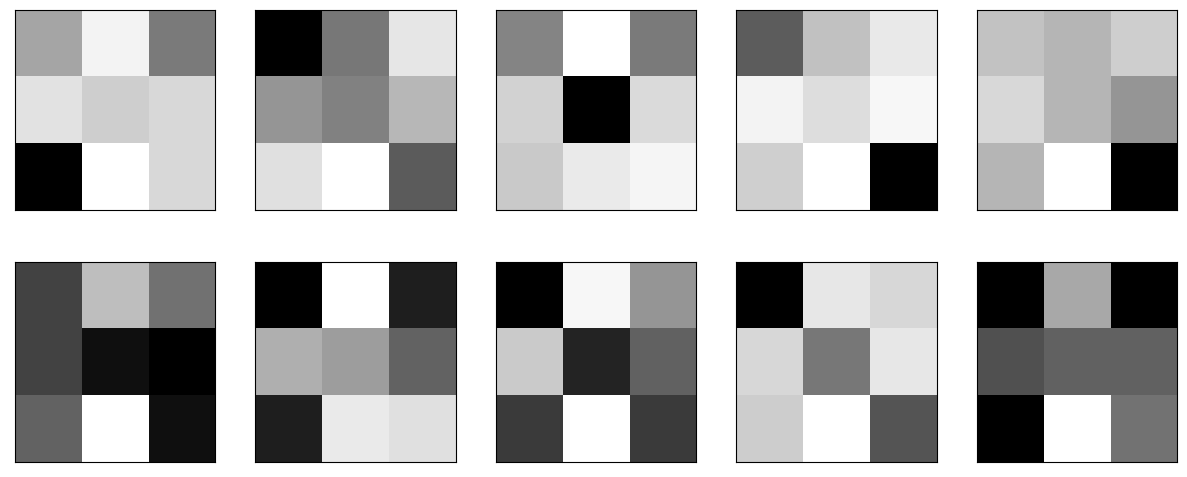

In [44]:
## Visualize documents from the prior-joint
_ = tpc_utils.visualize_random_docs(joint.sample()['W'], sqrt_V=sqrt_N_vocab)

### Defining the "observed" posterior:

In [45]:
def unnormalized_posterior(Pi, Theta):
    return joint.log_prob(W=words, Pi=Pi, Theta=Theta) # Incorporate data with "words"

---

### Defining & fitting surrogate posterior ($q$)

Actually the calculation of the variational inference just in math (see the [lecture](https://youtu.be/TcgeofQJYyM?t=4661)) would result in Dirichlet-Posteriors for $\Pi$ and $\Theta$ like
```python
    ## Priors:
    alphas = tf.Variable(2.*tf.ones((N_docs,  N_topics), dtype=tf.float32), name="alphas_Pi")
    betas  = tf.Variable(2.*tf.ones((N_topics, N_vocab), dtype=tf.float32), name="betas_Theta")

    ## Surrogate posterior
    surrogate_posterior = tfd.JointDistributionNamed(
        dict(
            Pi    = tfd.Dirichlet(alphas),
            Theta = tfd.Dirichlet(betas)),
        batch_ndims=0,
        use_vectorized_map=True,
        name="JointDirichlet")
```
Choosing this posterior works numerically really badly and is not presented here.

TensorFlow Probability provides an experimental utility [`tfp.experimental.vi.build_factored_surrogate_posterior`](https://www.tensorflow.org/probability/api_docs/python/tfp/experimental/vi/build_factored_surrogate_posterior) which by default assumes normal-distributed individual factors and therefore needs unconstraining bijectors because $\Theta$ and $\Pi$ are constrained to be positive. one could also try setting the `base_distribution_cls` to `tfd.Dirichlet` but this is as bad as constructing the posterior as presented above. Apart from that when using normal distributions the `vi.build_factored_surrogate_posterior` yields good results and seems to be really robust.

In [46]:
## Constraints
if use_softmax:
    unconstraining_bijectors = {
        'Pi':    tfb.SoftmaxCentered(),
        'Theta': tfb.SoftmaxCentered()}

## Similar but with other bijectors
if not use_softmax:
    unconstraining_bijectors = {
        'Pi':    tfb.Softplus(),
        'Theta': tfb.Softplus()}

## Using tfp.experimental.vi.build_factored_surrogate_posterior
if use_build_factored_surrogate_posterior:
    ## Event shapes (Omitting W)
    event_shape = {key: joint.event_shape_tensor()[key] for key in ('Pi', 'Theta')}
    surrogate_posterior = tfp.experimental.vi.build_factored_surrogate_posterior(
        event_shape=event_shape, 
        bijector=unconstraining_bijectors)


## Manually constructed Posterior
if not use_build_factored_surrogate_posterior:
    ## Priors:
    if use_softmax:
        Pi_dim2    = N_topics-1
        Theta_dim2 = N_vocab-1
    if not use_softmax:
        Pi_dim2    = N_topics
        Theta_dim2 = N_vocab
    means_Pi  = tf.Variable(tf.random.normal((N_docs,  Pi_dim2), dtype=tf.float32), name="means_Pi")
    scales_Pi = tf.Variable(tf.ones((N_docs,  Pi_dim2), dtype=tf.float32), name="scales_Pi")
    means_Theta  = tf.Variable(tf.random.normal((N_topics, Theta_dim2), dtype=tf.float32), name="means_Theta")
    scales_Theta = tf.Variable(tf.ones((N_topics, Theta_dim2), dtype=tf.float32), name="scales_Theta")
    ## Defining the joint
    surrogate_posterior_base = tfd.JointDistributionNamed(
        dict(
            Pi    = tfd.Normal(means_Pi, scales_Pi),
            Theta = tfd.Normal(means_Theta, scales_Theta)),
        batch_ndims=0,
        use_vectorized_map=True,
        name="JointNormal")
    ## Constraining to correct domains
    surrogate_posterior = tfd.TransformedDistribution(
        distribution=surrogate_posterior_base,
        bijector=tfb.JointMap(unconstraining_bijectors))

print(surrogate_posterior)

tfp.distributions._TransformedDistribution("jointmap_of_softmax_centered_and_softmax_centeredJointDistributionNamedAutoBatched", batch_shape=[], event_shape={Pi: [1000, 6], Theta: [6, 9]}, dtype={Pi: float32, Theta: float32})


In [47]:
## Setting training loop parameters
if use_build_factored_surrogate_posterior:
    learning_rate = 0.03
    N_steps = 500
    sample_size = 32

if not use_build_factored_surrogate_posterior:
    learning_rate = 0.01
    N_steps = 500
    sample_size = 64

@tf.function
def run_fit(surrogate_posterior):
    losses = tfp.vi.fit_surrogate_posterior(
        unnormalized_posterior,
        surrogate_posterior=surrogate_posterior,
        num_steps=N_steps,
        optimizer=tf.optimizers.Adam(learning_rate),
        sample_size=sample_size)
    return losses

losses = run_fit(surrogate_posterior)

---

## Assessing results 

Note that after the fit-process the surrogate posterior actually approximates the true posterior.

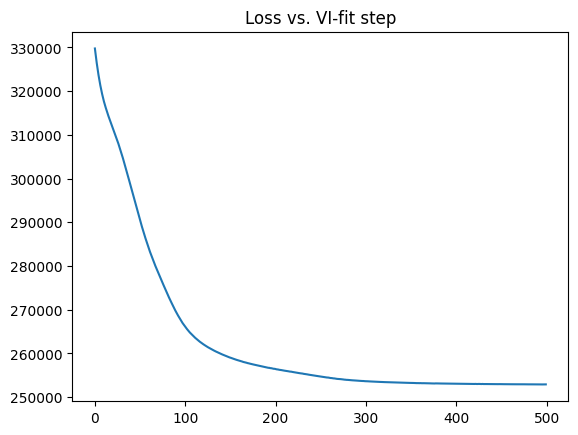

In [48]:
_ = sns.lineplot(
    x=np.arange(0, len(losses)), 
    y=losses
).set(
    title="Loss vs. VI-fit step"
)

In [49]:
sample = surrogate_posterior.sample(1000)
Thetas_sample = sample['Theta']
if not use_softmax:
    Thetas_sample = tf.nn.softmax(Thetas_sample) # For normalization

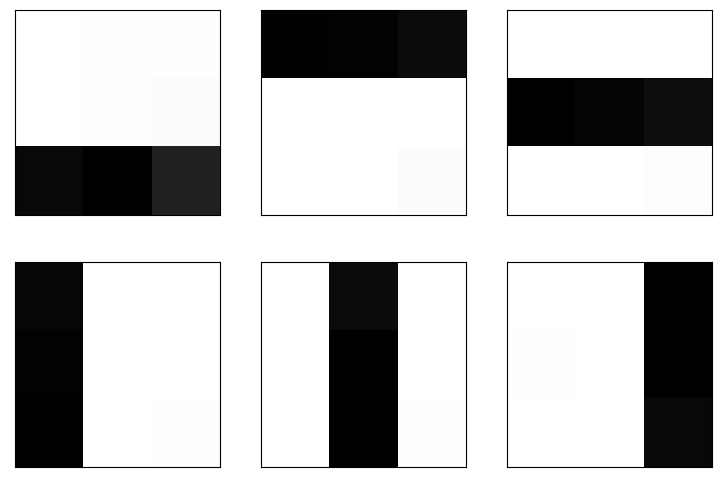

In [50]:
_ = tpc_utils.visualize_topics(tf.reduce_mean(Thetas_sample, axis=0), N_row=2, N_col=3)

Text(0.5, 1.0, '$\\Theta_{07}$ Sample Distribution')

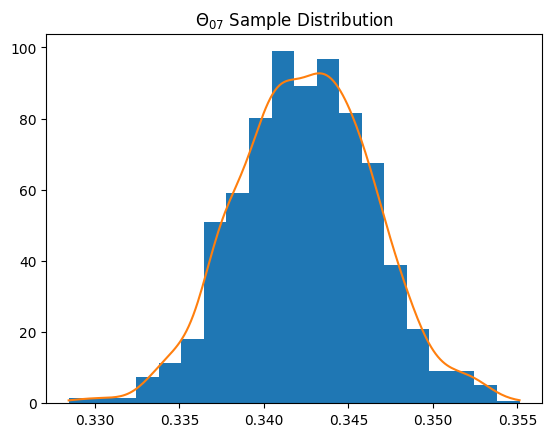

In [53]:
from scipy.stats import gaussian_kde, norm

theta_kv_sample = Thetas_sample[:, 0, 7].numpy()
density = gaussian_kde(theta_kv_sample)
xx = np.linspace(min(theta_kv_sample), max(theta_kv_sample), 200)

fig, ax = plt.subplots()
ax.hist(theta_kv_sample, bins=20, density=True, label="Histogram of sample")
ax.plot(xx, density(xx), label="KDE of sample")
ax.set_title("$\Theta_{07}$ Sample Distribution")